In [27]:
import numpy as np
import pandas as pd

import keras.backend as K
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 
from math import sqrt
from sklearn.metrics import mean_squared_error
from collections import Counter
from numpy import concatenate

from matplotlib import pyplot

In [ ]:
##############################################

### Generate the monthly df from daily df

In [28]:
# da = pd.read_csv('Whse_J_sort_out_index.csv')
# da.columns.values[0] = 'Date'
# da.index = pd.to_datetime(da['Date'])
# da.drop('Date', axis=1,inplace=True)
#取完整的年當資料集
# da = da[(da.index.year >=2012) &(da.index.year <=2016)]
# da['Year_Month'] = da.index.to_period('M')
# df = da.copy()

In [29]:
# df.info()

In [30]:
#generate new  df for experiment
# index1 = pd.date_range('2012-1', '2017-1' ,freq='M').to_period('M')
# column1 = df.columns.to_list()
# column1 = column1[0:-1]
# np1 = np.zeros((len(index1), len(column1)))
# df_test = pd.DataFrame(np1,index=index1,columns=column1,dtype='int64')
# df_test.head()

In [31]:
# df_test.loc[df_ym[i]][j]
# df[df.Year_Month == df_test.index[0]].iloc[:-1,4].sum()
# df[df.Year_Month == df_test.index[1]].iloc[:-1,0]

In [32]:
# #generate monthly df from daily df
# df_ym = df.index.to_period('M').unique()
# dftest_len = len(df_ym)
# for i in range(dftest_len):
#     k=0
#     for j in column1:
#         df_test.loc[df_ym[i]][j]=df[df.Year_Month == df_test.index[i]].iloc[:-1,k].sum()
#         k+=1
# # df_test.to_csv('Whse_J_sort_out_Month_aggressive.csv')
# df_test.head()

In [33]:
####################################################

In [34]:
df_test = pd.read_csv('Whse_J_sort_out_Month_aggressive.csv')
df_test.columns.values[0] = 'Year_Month'
df_test.index = pd.to_datetime(df_test['Year_Month'])
df_test.drop('Year_Month', axis=1,inplace=True)
df_test.head()

,Category_007-Product_0138,Category_021-Product_0282,Category_006-Product_0107,Category_001-Product_0609,Category_007-Product_0322,Category_005-Product_0031,Category_019-Product_1228,Category_024-Product_0289,Category_021-Product_0277,Category_024-Product_1898,...,Category_007-Product_0241,Category_007-Product_0242,Category_007-Product_0238,Category_007-Product_0239,Category_007-Product_0234,Category_007-Product_0244,Category_007-Product_0240,Category_007-Product_0233,Category_019-Product_2151,Category_021-Product_0853
Year_Month,,,,,,,,,,,,,,,,,,,,,
2012-01-01,1590,240,0,11,222,64600,4000,218,330,13,...,0,0,0,0,0,0,0,0,0,0
2012-02-01,13900,170,16000,10,227,86000,5000,34,620,8,...,0,0,0,0,0,0,0,0,0,0
2012-03-01,37695,210,6000,27,499,59600,6000,54,560,37,...,0,0,0,0,0,0,0,0,0,0
2012-04-01,2608,110,0,10,594,57100,7000,21,10,0,...,0,0,0,0,0,0,0,0,0,0
2012-05-01,5968,140,2000,12,372,49600,4000,10,10,3,...,0,0,0,0,0,0,0,0,0,0


### Naive forecast  單變數的序列預測

In [35]:
#naive forecast－單變數的序列預測
# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1] #單變數為１，多變數為shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    #generate t-1 col to forecast sequence (t, t+1, ... t+n)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]    
        
    #generate t, t+1, t+2 cols
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    print(agg)
    return agg
 
# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
    # extract raw values
    raw_values = series.values
    #由於shift需要是２Ｄ資料輸入
    raw_values = raw_values.reshape(len(raw_values), 1)
    # transform into supervised learning problem X, y
    supervised = series_to_supervised(raw_values, n_lag, n_seq)
    supervised_values = supervised.values
    # split into train and test sets
    train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
    return train, test
 
# make a persistence forecast
def persistence(last_ob, n_seq):
    return [last_ob for i in range(n_seq)]
 
# evaluate the persistence model
def make_forecasts(train, test, n_lag, n_seq):
    forecasts = list()
    for i in range(len(test)):
        X, y = test[i, 0:n_lag], test[i, n_lag:]
        # make forecast
        forecast = persistence(X[-1], n_seq)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
 
# evaluate the SMAPE for each forecast time step
epsilon = 0.1
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    for i in range(n_seq):
        actual = test[:,(n_lag+i)]
        print('   actual:  ',actual)
        predicted = [forecast[i] for forecast in forecasts]
        print('predicted:',predicted)
        summ = np.maximum(np.abs(actual)+np.abs(predicted)+0.1, 0.5+0.1)
        smape = np.mean(np.abs(predicted - actual) / summ) * 200.0
        print('t+%d SMAPE: %f' % ((i+1), smape))
        print('-'*70)

In [36]:
# choose the Category_007-Product_0138 for the product to predict
series = df_test[['Category_007-Product_0138']]
series[:20]

,Category_007-Product_0138
Year_Month,
2012-01-01,1590
2012-02-01,13900
2012-03-01,37695
2012-04-01,2608
2012-05-01,5968
2012-06-01,2022
2012-07-01,1061
2012-08-01,1512
2012-09-01,410


In [38]:
# configure
n_lag = 1
n_seq = 3
n_test = 10
# prepare data
train, test = prepare_data(series, n_test, n_lag, n_seq)
test

    var1(t-1)  var1(t)  var1(t+1)  var1(t+2)
1      1590.0    13900    37695.0     2608.0
2     13900.0    37695     2608.0     5968.0
3     37695.0     2608     5968.0     2022.0
4      2608.0     5968     2022.0     1061.0
5      5968.0     2022     1061.0     1512.0
6      2022.0     1061     1512.0      410.0
7      1061.0     1512      410.0     2857.0
8      1512.0      410     2857.0     7139.0
9       410.0     2857     7139.0     7574.0
10     2857.0     7139     7574.0     2991.0
11     7139.0     7574     2991.0     1227.0
12     7574.0     2991     1227.0     1373.0
13     2991.0     1227     1373.0     1561.0
14     1227.0     1373     1561.0     3505.0
15     1373.0     1561     3505.0     4662.0
16     1561.0     3505     4662.0     2327.0
17     3505.0     4662     2327.0     1747.0
18     4662.0     2327     1747.0     2207.0
19     2327.0     1747     2207.0     1723.0
20     1747.0     2207     1723.0     2956.0
21     2207.0     1723     2956.0     3844.0
22     172

array([[2599., 1401., 1789., 2468.],
       [1401., 1789., 2468., 1249.],
       [1789., 2468., 1249., 5229.],
       [2468., 1249., 5229., 1231.],
       [1249., 5229., 1231., 2638.],
       [5229., 1231., 2638., 3220.],
       [1231., 2638., 3220.,  516.],
       [2638., 3220.,  516., 4414.],
       [3220.,  516., 4414., 2774.],
       [ 516., 4414., 2774., 3120.]])

In [39]:
# make forecasts
#[[2599.0, 2599.0, 2599.0],..做出３個預測欄位，之後要與３個時間序列真實值比較
forecasts = make_forecasts(train, test, n_lag, n_seq)

In [41]:
forecasts

[[2599.0, 2599.0, 2599.0],
 [1401.0, 1401.0, 1401.0],
 [1789.0, 1789.0, 1789.0],
 [2468.0, 2468.0, 2468.0],
 [1249.0, 1249.0, 1249.0],
 [5229.0, 5229.0, 5229.0],
 [1231.0, 1231.0, 1231.0],
 [2638.0, 2638.0, 2638.0],
 [3220.0, 3220.0, 3220.0],
 [516.0, 516.0, 516.0]]

In [42]:
# evaluate forecasts
evaluate_forecasts(test, forecasts, n_lag, n_seq)

   actual:   [1401. 1789. 2468. 1249. 5229. 1231. 2638. 3220.  516. 4414.]
predicted: [2599.0, 1401.0, 1789.0, 2468.0, 1249.0, 5229.0, 1231.0, 2638.0, 3220.0, 516.0]
t+1 SMAPE: 82.384344
----------------------------------------------------------------------
   actual:   [1789. 2468. 1249. 5229. 1231. 2638. 3220.  516. 4414. 2774.]
predicted: [2599.0, 1401.0, 1789.0, 2468.0, 1249.0, 5229.0, 1231.0, 2638.0, 3220.0, 516.0]
t+2 SMAPE: 65.915078
----------------------------------------------------------------------
   actual:   [2468. 1249. 5229. 1231. 2638. 3220.  516. 4414. 2774. 3120.]
predicted: [2599.0, 1401.0, 1789.0, 2468.0, 1249.0, 5229.0, 1231.0, 2638.0, 3220.0, 516.0]
t+3 SMAPE: 59.090734
----------------------------------------------------------------------


In [366]:
#################################################

### LSTM Model 

In [384]:
# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 

#transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
    # extract raw values
    raw_values = series.values
    diff_values = raw_values.reshape(len(raw_values), 1)
    # rescale values to 0, 1
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_values = scaler.fit_transform(diff_values)
    scaled_values = scaled_values.reshape(len(scaled_values), 1)
    # transform into supervised learning problem X, y
    supervised = series_to_supervised(scaled_values, n_lag, n_seq)
    supervised_values = supervised.values
    # split into train and test sets
    train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
    return scaler, train, test

# Define SMAPE loss function
def customLoss(true,predicted):
    epsilon = 0.1
    summ = K.maximum(K.abs(true) + K.abs(predicted) + epsilon, 0.5 + epsilon)
    smape = K.mean(K.abs(predicted - true) / summ) * 200.0
    return smape
 
# fit an LSTM network to training data
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    # reshape training into [samples, timesteps, features]
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    # design network
    model = Sequential()
    model.add(LSTM(n_neurons ,batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(y.shape[1]))

    model.compile(loss=customLoss, optimizer='adam')
    
    # fit network
    loss=list()
    val_loss=list()
    for i in range(nb_epoch):
        history=model.fit(X, y, epochs=1, batch_size=n_batch, verbose=1,validation_split=0.25, shuffle=False)
        eqm=history.history['loss']
        eqm_val=history.history['val_loss']
        loss.append(eqm)
        val_loss.append(eqm_val)
        model.reset_states()
    return  model,loss,val_loss
 
# make one forecast with an LSTM
def forecast_lstm(model, X, n_batch):
    # reshape input pattern to [samples, timesteps, features]
    print('forecast:X_in.shape:',X.shape)
    X = X.reshape(1, 1, len(X))
    print('forecast:X_reshape:',X.shape)
    # make forecast
    forecast = model.predict(X, batch_size=n_batch)
    print('forecast:',forecast)
    print('forecast:',forecast.shape)
    # convert to array
    return [x for x in forecast[0, :]]
 
# evaluate the persistence model
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
    forecasts = list()
    for i in range(len(test)):
        X, y = test[i, 0:n_lag], test[i, n_lag:]
        # make forecast
        forecast = forecast_lstm(model, X, n_batch)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
 
# invert differenced forecast
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
 
# inverse data transform on forecasts
def inverse_transform(series, forecasts, scaler, n_test):
    inverted = list()
    for i in range(len(forecasts)):
        # create array from forecast
        forecast = np.array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :].tolist()
        print('inv_scale:',inv_scale)       
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inverted.append(inv_scale)
    return inverted
 
# evaluate the RMSE for each forecast time step
epsilon = 0.1
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    for i in range(n_seq):
        actual = [row[i] for row in test]
        print('   actual:  ',actual)
        predicted = [forecast[i] for forecast in forecasts]
        print('predicted:',predicted)
        summ = np.maximum(np.abs(actual)+np.abs(predicted)+0.1, 0.5+0.1)
        smape = np.mean(np.abs(np.subtract(predicted,actual)) / summ) * 200.0
        print('t+%d SMAPE: %f' % ((i+1), smape))


In [385]:
# load dataset　　and choose the 'Category_007-Product_0138' for our product to forecast
series = df_test['Category_007-Product_0138']
# series[-12:]

In [386]:
# configure
n_lag = 1
n_seq = 3
n_test = 10
n_epochs = 100
n_batch = 1
n_neurons = 4
# prepare data
scaler, train, test = prepare_data(series, n_test, n_lag, n_seq)


Train on 35 samples, validate on 12 samples
Epoch 1/1
35/35 [==============================] - 1s 41ms/step - loss: 19.0847 - val_loss: 9.4149
Train on 35 samples, validate on 12 samples
Epoch 1/1
35/35 [==============================] - 0s 2ms/step - loss: 16.0642 - val_loss: 10.5095
Train on 35 samples, validate on 12 samples
Epoch 1/1
35/35 [==============================] - 0s 2ms/step - loss: 15.9640 - val_loss: 10.0578
Train on 35 samples, validate on 12 samples
Epoch 1/1
35/35 [==============================] - 0s 2ms/step - loss: 15.8163 - val_loss: 9.7036
Train on 35 samples, validate on 12 samples
Epoch 1/1
35/35 [==============================] - 0s 2ms/step - loss: 15.7832 - val_loss: 9.5044
Train on 35 samples, validate on 12 samples
Epoch 1/1
35/35 [==============================] - 0s 2ms/step - loss: 15.7013 - val_loss: 9.4742
Train on 35 samples, validate on 12 samples
Epoch 1/1
35/35 [==============================] - 0s 2ms/step - loss: 15.7235 - val_loss: 9.4664
Tra

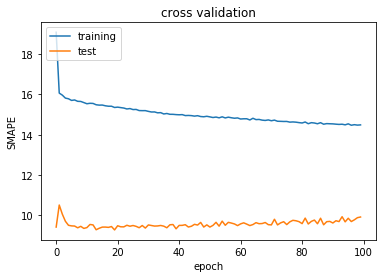

In [387]:
# fit model
model,loss,val_loss= fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)
pyplot.figure()
pyplot.plot(loss)
pyplot.plot(val_loss)
pyplot.title('cross validation')
pyplot.ylabel('SMAPE')
pyplot.xlabel('epoch')
pyplot.legend(['training', 'test'], loc='upper left')
pyplot.show()

In [388]:
# make forecasts
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)
forecasts

forecast:X_in.shape: (1,)
forecast:X_reshape: (1, 1, 1)
forecast: [[0.04152905 0.05383682 0.06029691]]
forecast: (1, 3)
forecast:X_in.shape: (1,)
forecast:X_reshape: (1, 1, 1)
forecast: [[0.04520202 0.05786103 0.06406526]]
forecast: (1, 3)
forecast:X_in.shape: (1,)
forecast:X_reshape: (1, 1, 1)
forecast: [[0.04764581 0.06012863 0.06592368]]
forecast: (1, 3)
forecast:X_in.shape: (1,)
forecast:X_reshape: (1, 1, 1)
forecast: [[0.04928239 0.061477   0.06629063]]
forecast: (1, 3)
forecast:X_in.shape: (1,)
forecast:X_reshape: (1, 1, 1)
forecast: [[0.04988615 0.05996379 0.06646252]]
forecast: (1, 3)
forecast:X_in.shape: (1,)
forecast:X_reshape: (1, 1, 1)
forecast: [[0.05144271 0.06385515 0.06464992]]
forecast: (1, 3)
forecast:X_in.shape: (1,)
forecast:X_reshape: (1, 1, 1)
forecast: [[0.05059536 0.05857976 0.06361532]]
forecast: (1, 3)
forecast:X_in.shape: (1,)
forecast:X_reshape: (1, 1, 1)
forecast: [[0.0510329  0.05845622 0.06285632]]
forecast: (1, 3)
forecast:X_in.shape: (1,)
forecast:X_res

[[0.041529052, 0.053836815, 0.060296908],
 [0.04520202, 0.057861034, 0.06406526],
 [0.04764581, 0.06012863, 0.065923676],
 [0.049282387, 0.061477, 0.06629063],
 [0.049886152, 0.059963785, 0.066462524],
 [0.051442705, 0.06385515, 0.06464992],
 [0.050595358, 0.058579758, 0.06361532],
 [0.051032905, 0.05845622, 0.06285632],
 [0.0513288, 0.058332823, 0.061746046],
 [0.050664864, 0.054373108, 0.061814647]]

In [389]:
# inverse transform forecasts and test
forecasts = inverse_transform(series, forecasts, scaler, n_test+2)
print('forecasts:',forecasts)
actual = [row[n_lag:] for row in test]
print('actual0:',actual)
actual = inverse_transform(series, actual, scaler, n_test+2)
print('actual1:',actual)

inv_scale: [1798.3460693359375, 2259.29638671875, 2501.239990234375]
inv_scale: [1935.906005859375, 2410.011474609375, 2642.372314453125]
inv_scale: [2027.430908203125, 2494.9375, 2711.9736328125]
inv_scale: [2088.723876953125, 2545.436767578125, 2725.716796875]
inv_scale: [2111.336181640625, 2488.763916015625, 2732.154541015625]
inv_scale: [2169.632080078125, 2634.503173828125, 2664.268798828125]
inv_scale: [2137.897216796875, 2436.92919921875, 2625.521240234375]
inv_scale: [2154.284423828125, 2432.302490234375, 2597.094970703125]
inv_scale: [2165.3662109375, 2427.680908203125, 2555.512939453125]
inv_scale: [2140.50048828125, 2279.381591796875, 2558.08203125]
forecasts: [[1798.3460693359375, 2259.29638671875, 2501.239990234375], [1935.906005859375, 2410.011474609375, 2642.372314453125], [2027.430908203125, 2494.9375, 2711.9736328125], [2088.723876953125, 2545.436767578125, 2725.716796875], [2111.336181640625, 2488.763916015625, 2732.154541015625], [2169.632080078125, 2634.503173828125

   actual:   [1401.0, 1789.0, 2468.0, 1248.9999999999998, 5229.0, 1231.0, 2638.0, 3220.0000000000005, 516.0, 4414.0]
predicted: [1798.3460693359375, 1935.906005859375, 2027.430908203125, 2088.723876953125, 2111.336181640625, 2169.632080078125, 2137.897216796875, 2154.284423828125, 2165.3662109375, 2140.50048828125]
t+1 SMAPE: 49.578089
   actual:   [1789.0, 2468.0, 1248.9999999999998, 5229.0, 1231.0, 2638.0, 3220.0000000000005, 516.0, 4414.0, 2774.0]
predicted: [2259.29638671875, 2410.011474609375, 2494.9375, 2545.436767578125, 2488.763916015625, 2634.503173828125, 2436.92919921875, 2432.302490234375, 2427.680908203125, 2279.381591796875]
t+2 SMAPE: 46.427237
   actual:   [2468.0, 1248.9999999999998, 5229.0, 1231.0, 2638.0, 3220.0000000000005, 516.0, 4414.0, 2774.0, 3120.0]
predicted: [2501.239990234375, 2642.372314453125, 2711.9736328125, 2725.716796875, 2732.154541015625, 2664.268798828125, 2625.521240234375, 2597.094970703125, 2555.512939453125, 2558.08203125]
t+3 SMAPE: 44.840328
o

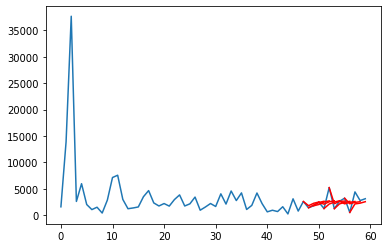

In [390]:
# evaluate forecasts
evaluate_forecasts(actual, forecasts, n_lag, n_seq)
